In [1]:
import deepSI
import numpy as np

class DuffingOscillator(deepSI.System_deriv):
    def __init__(self):
        super(DuffingOscillator, self).__init__(nx=2, dt=0.1)
        self.alpha = 1
        self.beta = 5
        self.gamma = 1
        self.delta = 0.02
        self.omega = 0.5

    def deriv(self,x,u):
        z1,z2 = x
        dz1 = self.gamma*u - self.delta*z1 - self.alpha*z2 - self.beta*(z2**3)
        dz2 = z1
        return [dz1,dz2]

    def h(self,x,u):
        return x

In [2]:
from matplotlib import pyplot as plt
u = deepSI.deepSI.exp_design.multisine(80000, pmax=101)
#plt.plot(u)

In [3]:
sys = DuffingOscillator()
data = sys.apply_experiment(deepSI.System_data(u=u))
data.y.shape

(80000, 2)

In [4]:
from torch import nn
class I_encoder(deepSI.fit_systems.SS_encoder):
    def __init__(self, nx = 2, na=2, nb=2, feedthrough=False) -> None:
        super().__init__(nx=nx, na=na, nb=nb, feedthrough=feedthrough)

    def init_nets(self, nu, ny): # a bit weird
        ny = ny if ny is not None else 1
        nu = nu if nu is not None else 1
        self.encoder = self.e_net(self.nb*nu+self.na*ny, self.nx, n_nodes_per_layer=self.e_n_nodes_per_layer, n_hidden_layers=self.e_n_hidden_layers, activation=self.e_activation)
        self.fn =      self.f_net(self.nx+nu,            self.nx, n_nodes_per_layer=self.f_n_nodes_per_layer, n_hidden_layers=self.f_n_hidden_layers, activation=self.f_activation)
        hn_in = self.nx + nu if self.feedthrough else self.nx
        self.hn =      nn.Identity(hn_in)#self.h_net(hn_in     ,            ny,      n_nodes_per_layer=self.h_n_nodes_per_layer, n_hidden_layers=self.h_n_hidden_layers, activation=self.h_activation)

In [5]:
I_enc = I_encoder(nx=2, na=2, nb=2, feedthrough=False)
train, test = data.train_test_split(split_fraction=0.2)
train, val  = train.train_test_split(split_fraction=0.25)

I_enc.fit(train_sys_data=train, val_sys_data=val, epochs=5, batch_size=256, loss_kwargs={'nf':50})

Initilizing the model and optimizer
Size of the training array =  57.1 MB
N_training_samples = 47949, batch_size = 256, N_batch_updates_per_epoch = 187
Initial Validation sim-NRMS= 1.027080034741586


  0%|          | 0/5 [00:00<?, ?it/s]

########## New lowest validation loss achieved ########### sim-NRMS = 0.5043756029920967
Epoch    1, sqrt loss  0.7019, Val sim-NRMS 0.5044, Time Loss: 80.8%, data: 0.6%, val: 18.5%, 14.6 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.4769511785504238
Epoch    2, sqrt loss  0.6449, Val sim-NRMS  0.477, Time Loss: 79.9%, data: 0.6%, val: 19.6%, 16.6 batches/sec
Epoch    3, sqrt loss    0.64, Val sim-NRMS 0.4977, Time Loss: 79.2%, data: 0.6%, val: 20.2%, 17.4 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.4747506281789231
Epoch    4, sqrt loss  0.6378, Val sim-NRMS 0.4748, Time Loss: 78.9%, data: 0.5%, val: 20.5%, 17.9 batches/sec
########## New lowest validation loss achieved ########### sim-NRMS = 0.46178031841506806
Epoch    5, sqrt loss  0.6341, Val sim-NRMS 0.4618, Time Loss: 78.7%, data: 0.5%, val: 20.7%, 18.0 batches/sec
Loaded model with best known validation sim-NRMS of 0.4618 which happened on epoch 5 (ep

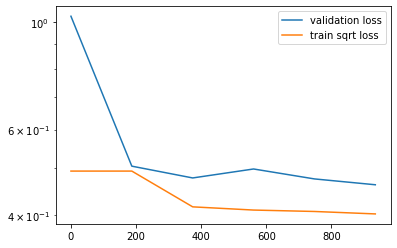

In [6]:
I_enc.checkpoint_load_system('_last')
plt.semilogy(I_enc.batch_id,I_enc.Loss_val,label='validation loss')
plt.semilogy(I_enc.batch_id,I_enc.Loss_train,label='train sqrt loss')
plt.legend()

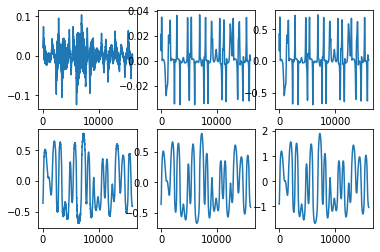

In [7]:
test_ss_enc = I_enc.apply_experiment(test,save_state=True)
X = test_ss_enc.x

plt.subplot(2,3,1)
plt.plot(test.y[:,0])
plt.subplot(2,3,2)
plt.plot(test_ss_enc.y[:,0])
plt.subplot(2,3,3)
plt.plot(X[:,0])

plt.subplot(2,3,4)
plt.plot(test.y[:,1])
plt.subplot(2,3,5)
plt.plot(test_ss_enc.y[:,1])
plt.subplot(2,3,6)
plt.plot(X[:,1])

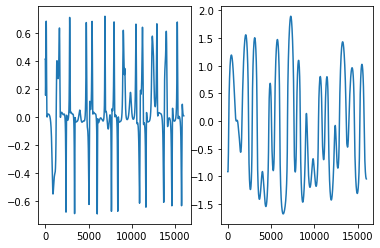

In [8]:
X = test_ss_enc.x
plt.subplot(1,2,1)
plt.plot(X[:,0])
plt.subplot(1,2,2)
plt.plot(X[:,1])